In [1]:
%pylab inline
from PIL import Image
import os
import pandas as pd
import pylab as pl

Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_images(img_dir, grayscale=False):
    """Loads images from within a specified directory.

    Args:
      img_dir (str): The directory from which to load (.jpg) images.
      grayscale (bool): Whether to convert the image into grayscale. Defaults to False.

    Returns:
      images: An array of image objects loaded from the specified directory

    """
    images = []

    for file in os.listdir(img_dir):
        if file.endswith(".jpg"):
            im = Image.open(os.path.join(img_dir, file))

            im = im.resize((100, 100))

            if grayscale:
                im = np.array(im, dtype=np.float64) / 255

                # Convert image to grayscale
                r, g, b = im[:,:,0], im[:,:,1], im[:,:,2]
                gray = 0.2989*r + 0.5870*g + 0.1140*b
                im = gray.reshape((1, -1))[0]

            images.append(im)

    return images

def plot_image_space(images, X, title="Projection of the Images into 2 Dimensions"):
    """Generates and shows a plot of images in a feature space.

    A figure with one plot is generated. The plot displays the location of each image in 
    relation to the image's feature values in the input feature space (X).

    Args:
      images (Image): An image.
      images (SciPy array): An array of SSQs, one computed for each k.

    """
    # min-max normalization    
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    X = (X - x_min) / (x_max - x_min)

    # Create a figure
    pl.figure(figsize=(16, 5))
    ax = pl.subplot(111)
    #ax.axis('off')

    # Generate picture thumbnails in the plot
    if hasattr(matplotlib.offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        for i in range(len(images)):
            imagebox = matplotlib.offsetbox.OffsetImage(images[i], zoom=.65)
            ab = matplotlib.offsetbox.AnnotationBbox(imagebox, X[i][0:2])                                  
            ax.add_artist(ab)

    # Add figure labels and ticks
    pl.title(title, fontsize=16)
    pl.xticks([]), pl.yticks([])

    # Add figure bounds
    pl.ylim((np.min(X, axis=0)[1])-0.25,(np.max(X, axis=0)[1])+0.25)
    pl.xlim((np.min(X, axis=0)[0])-0.1,(np.max(X, axis=0)[0])+0.1)

In [3]:
img_dir = os.path.join(os.getcwd(), "images") # directory path
images = load_images(img_dir) # load images in the specified directory

In [4]:
X = pd.DataFrame([im.histogram() for im in images])

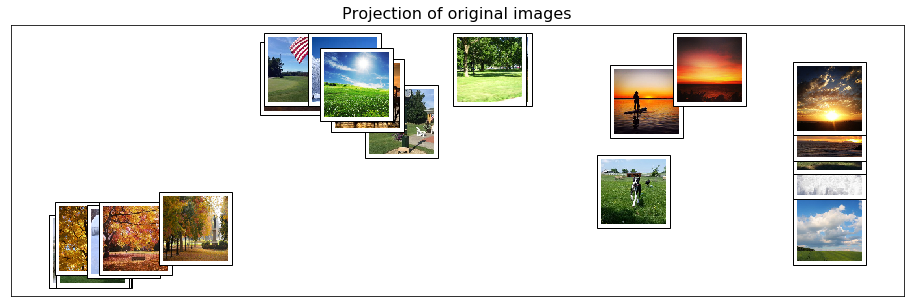

In [5]:
plot_image_space(images,X,'Projection of original images')

In [6]:
from sklearn import decomposition
# Compute (two-dimensional) PCA on the images dataset

#print("Computing PCA projection..."),
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X)

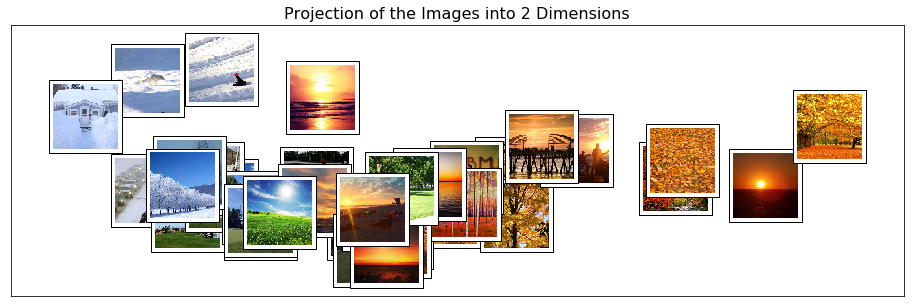

In [7]:
plot_image_space(images,X_pca)

Question 2

By performing PCA on an image histogram, we are only reducing an image from a set of 768 unique histogram values (rather than the 65,000 unique pixel values) to a new 2- dimensional space. As a result of this transformation,
images that have a similar histogram should also be similar in this 2-dimensional space.

As the palettes are generated via (k-means) clustering of the pixel color values, the list of images are clustered according to how similar their pixel color values are. This is why all the cold color images are clustered together and warm color images are clustered together. 

So if two images are close together then that means their similarity of pixel color values is high. And opposite is the case with images which are far apart i.e their similarity of pixel color values is low.

Question 3

I am going to try PCA algorithm on different set of images placed in RandomImages folder. These images are sunset , sunrise and day time of same place.

In [8]:
img_dir_3 = os.path.join(os.getcwd(), "RandomImages") # directory path
images_3 = load_images(img_dir_3) # load images in the specified directory

In [9]:
X_3 = pd.DataFrame([im.histogram() for im in images_3])

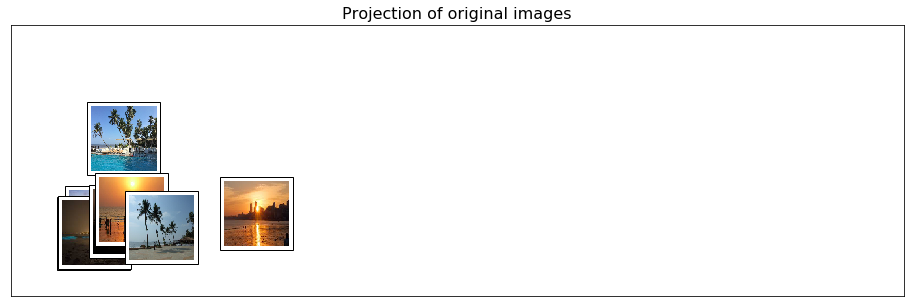

In [30]:
plot_image_space(images_3,X_3,'Projection of original images')

In [11]:
#print("Computing PCA projection..."),
pca_3 = decomposition.PCA(n_components=2)
X_pca_3 = pca_3.fit_transform(X_3)

IndexError: index 8 is out of bounds for axis 0 with size 8

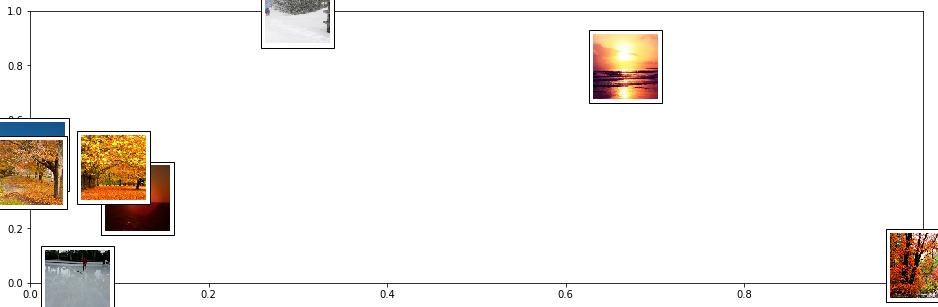

In [12]:
plot_image_space(images,X_pca_3, 'Projection of the Images into 2 Dimensions (using PCA)')

After applying PCA, I observed that PCA is clustering images on amount of color values each image has, but unfortunately it is failing to cluster all dark images together.

Below, I tried applying LLE on a new set of 8 images which are describe by histogram of 768 color values

In [40]:
#print("Computing LLE..."),
clf_3 = manifold.LocallyLinearEmbedding(n_neighbors=3, n_components=2, method='standard')
X_lle_3 = clf_3.fit_transform(X_3)
#print("done. Reconstruction error: %g" % clf.reconstruction_error_)

IndexError: index 8 is out of bounds for axis 0 with size 8

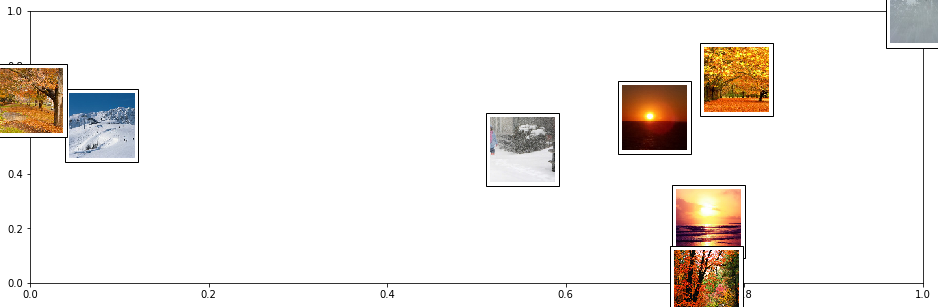

In [41]:
# Plot LLE result
plot_image_space(images,X_lle_3, 'Projection of the Images into 2 Dimensions (using LLE)')

With LLE, images are clustered between daytime images and dark (sunset/sunrise) images. Dark images are more closer than whatwe have observed in PCA analysis. However, there is no clear separation between images of sunrise and sunset.

Looks like, somehow PCA does take intensity of colors into its account whereas LLE doesn't.